## 1. Imports & Config.

In [129]:
import os
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from astropy.io import fits

data_dir = os.path.join(os.getcwd(), 'data')

obsid = '1342203292'  # observation id

level = 'level2_5'

lambda_um = 500

array = {250: 'PSW', 350: 'PMW', 500: 'PLW'}[lambda_um]

# possible types:
#   extd: extended-source calibrated (MJy/sr)
#   hires: extended-source calibrated, hi-res (Richardson-Lucy deconvolution, MJy/sr)
#   psrc: point-source calibrated (Jy/beam)

type = 'hires'

product = f'{type}{array}'

obs_dir = os.path.join(data_dir, obsid)
level_dir = os.path.join(obs_dir, level)
prod_dir = os.path.join(level_dir, product)

## 2. Load the Observation Context

In [130]:
obs_fnames = os.listdir(obs_dir)
level_fnames = os.listdir(level_dir)

obs_ctxts = [f for f in obs_fnames if f.endswith('.fits')]
level_ctxts = [f for f in level_fnames if f.endswith('.fits')]

assert len(level_ctxts) == 1
assert len(obs_ctxts) == 1

obs_ctxt = fits.open(os.path.join(obs_dir, obs_ctxts[0]))
level_ctxt = fits.open(os.path.join(level_dir, level_ctxts[0]))

In [131]:
print("Observation Context:")
obs_ctxt.info()
breakpoint()

Observation Context:
Filename: C:\Users\Jonah\PycharmProjects\spire_blasttng_diff\data\1342203292\hspire1342203292obs_1476909200304.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     148   ()      
  1  History       1 ImageHDU        23   ()      
  2  HistoryScript    1 BinTableHDU     39   7R x 1C   [54A]   
  3  HistoryTasks    1 BinTableHDU     46   2R x 4C   [1K, 14A, 1K, 9A]   
  4  HistoryParameters    1 BinTableHDU     74   6R x 10C   [1K, 16A, 7A, 14A, 1L, 1K, 1L, 34A, 4A, 0A]   
  5  context       1 ImageHDU        20   ()      
  6  bridges       1 BinTableHDU     37   13R x 2C   [18A, 59A]   


In [132]:
print("\n\nLevel Context:")
level_ctxt.info()



Level Context:
Filename: C:\Users\Jonah\PycharmProjects\spire_blasttng_diff\data\1342203292\level2_5\hspire465_25level25context_1513_m5736_1342203291_1342203292_1462481543402.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      93   ()      
  1  context       1 ImageHDU        20   ()      
  2  bridges       1 BinTableHDU     37   16R x 2C   [13A, 64A]   


## 3. Load Image Data

In [133]:
# each product directory contains a single .fits file
prod_fnames = os.listdir(prod_dir)
assert len(prod_fnames) == 1, "only one file expected"
assert prod_fnames[0].endswith('.fits'), "file should be in .fits format"

fits_filename = os.path.join(prod_dir, prod_fnames[0])

# open the only file in the directory
hdul = fits.open(fits_filename)  # Header Data Unit list
hdul.info()

Filename: C:\Users\Jonah\PycharmProjects\spire_blasttng_diff\data\1342203292\level2_5\hiresPLW\hspireplw1342203291_25hirespxmp_1462481003485.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     163   ()      
  1  image         1 ImageHDU        49   (1776, 1836)   float64   
  2  cfv           1 ImageHDU        47   (1776, 1836)   float64   
  3  coverage      1 ImageHDU        49   (1776, 1836)   float64   
  4  History       1 ImageHDU        23   ()      
  5  HistoryScript    1 BinTableHDU     39   10R x 1C   [326A]   
  6  HistoryTasks    1 BinTableHDU     46   3R x 4C   [1K, 16A, 1K, 9A]   
  7  HistoryParameters    1 BinTableHDU     74   25R x 10C   [1K, 18A, 13A, 196A, 1L, 1K, 1L, 47A, 11A, 28A]   


## 4. Plot Images

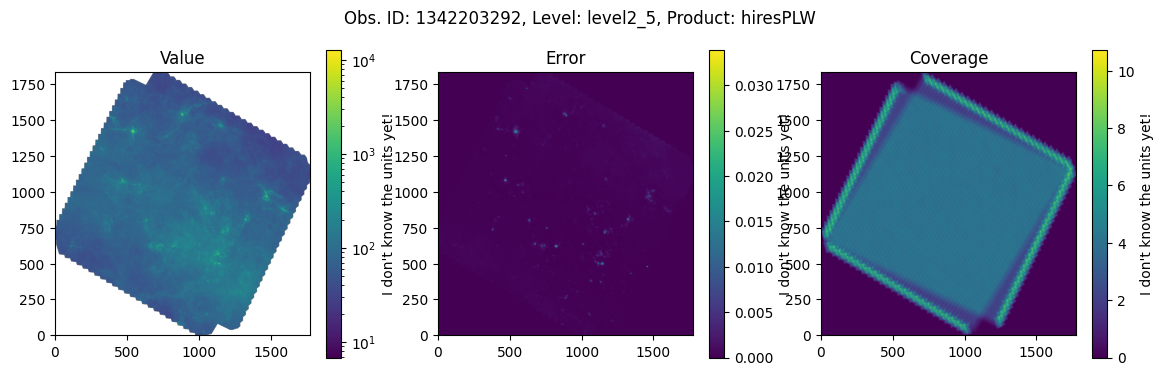

XTENSION= 'IMAGE   '           / Java FITS: Thu May 05 16:46:01 CEST 2016       
BITPIX  =                  -64                                                  
NAXIS   =                    2 / Dimensionality                                 
NAXIS1  =                 1776                                                  
NAXIS2  =                 1836                                                  
PCOUNT  =                    0 / No extra parameters                            
GCOUNT  =                    1 / One group                                      
LONGSTRN= 'OGIP 1.0'           / The OGIP long string convention may be used.   
COMMENT This FITS file may contain long string keyword values that are          
COMMENT continued over multiple keywords.  This convention uses the  '&'        
COMMENT character at the end of a string which is then continued                
COMMENT on subsequent keywords whose name = 'CONTINUE'.                         
          -------------- Her

In [134]:
log_norm = colors.LogNorm()

fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, sharex=False, sharey=False, figsize=(14, 4))
fig.suptitle(f"Obs. ID: {obsid}, Level: {level}, Product: {product}")

img = hdul[1].data
ax1.set_title("Value")
fig1 = ax1.imshow(img, cmap='viridis', norm=log_norm, origin='lower')
plt.colorbar(fig1, ax=ax1, label="I don't know the units yet!")

error = hdul[2].data
ax2.set_title("Error")
fig2 = ax2.imshow(error, cmap='viridis', origin='lower')
plt.colorbar(fig2, ax=ax2, label="I don't know the units yet!")

coverage = hdul[3].data
ax3.set_title("Coverage")
fig3 = ax3.imshow(coverage, cmap='viridis', origin='lower')
plt.colorbar(fig3, ax=ax3, label="I don't know the units yet!")

plt.show()

hdul[1].header